In [65]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid
import os

In [66]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # 定义编码器
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2,inplace=True),
        )
        self.encoder_fc1=nn.Linear(32*7*7,nz)
        self.encoder_fc2=nn.Linear(32*7*7,nz)
        self.Sigmoid = nn.Sigmoid()
        self.decoder_fc = nn.Linear(nz+10,32 * 7 * 7)
        self.decoder_deconv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, 4, 2, 1),
            nn.Sigmoid(),
        )

    def noise_reparameterize(self,mean,logvar):
        eps = torch.randn(mean.shape).to(device)
        z = mean + eps * torch.exp(logvar)
        return z

    def forward(self, x):
        z = self.encoder(x)
        output = self.decoder(z)
        return output
    def encoder(self,x):
        out1, out2 = self.encoder_conv(x), self.encoder_conv(x)
        mean = self.encoder_fc1(out1.view(out1.shape[0], -1))
        logstd = self.encoder_fc2(out2.view(out2.shape[0], -1))
        z = self.noise_reparameterize(mean, logstd)
        return z,mean,logstd
    def decoder(self,z):
        out3 = self.decoder_fc(z)
        out3 = out3.view(out3.shape[0], 32, 7, 7)
        out3 = self.decoder_deconv(out3)
        return out3

In [67]:
class Discriminator(nn.Module):
    def __init__(self,outputn=1):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d((2, 2)),
        )
        self.fc = nn.Sequential(
            nn.Linear(7 * 7 * 64, 1024),
            nn.LeakyReLU(0.2, True),
            nn.Linear(1024, outputn),
            nn.Sigmoid()
        )

    def forward(self, input):
        x = self.dis(input)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x.squeeze(1)

In [68]:
def loss_function(recon_x,x,mean,logstd):
    # BCE = F.binary_cross_entropy(recon_x,x,reduction='sum')
    MSE = MSECriterion(recon_x,x)
    # 因为var是标准差的自然对数，先求自然对数然后平方转换成方差
    var = torch.pow(torch.exp(logstd),2)
    KLD = -0.5 * torch.sum(1+torch.log(var)-torch.pow(mean,2)-var)
    return MSE+KLD


In [69]:
dataset = 'mnist'
batchSize = 128
imageSize = 28
nz=100
nepoch=200
if not os.path.exists('./img_CVAE-GAN'):
    os.mkdir('./img_CVAE-GAN')
print("Random Seed: 88")
random.seed(88)
torch.manual_seed(88)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 可以优化运行效率
cudnn.benchmark = True
dataset = dset.MNIST(root='./data',
                        train=True,
                        transform=transforms.Compose([transforms.ToTensor()]),
                        download=True
                        )
n_channel = 1
dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=batchSize,
                                            shuffle=True)

Random Seed: 88


In [70]:
print("=====> 构建VAE")
vae = VAE().to(device)
# vae.load_state_dict(torch.load('./CVAE-GAN-VAE.pth'))
print("=====> 构建D")
D = Discriminator(1).to(device)
# D.load_state_dict(torch.load('./CVAE-GAN-Discriminator.pth'))
print("=====> 构建C")
C = Discriminator(10).to(device)
# C.load_state_dict(torch.load('./CVAE-GAN-Classifier.pth'))
criterion = nn.BCELoss().to(device)
MSECriterion = nn.MSELoss().to(device)

print("=====> Setup optimizer")
optimizerD = optim.Adam(D.parameters(), lr=0.0001)
optimizerC = optim.Adam(C.parameters(), lr=0.0001)
optimizerVAE = optim.Adam(vae.parameters(), lr=0.0001)

=====> 构建VAE
=====> 构建D
=====> 构建C
=====> Setup optimizer


In [71]:
import matplotlib.pyplot as plt

losses_D, losses_C, losses_G = [], [], []

for epoch in range(nepoch):
    for i, (data,label) in enumerate(dataloader, 0):
        # 先处理一下数据
        data = data.to(device)
        label_onehot = torch.zeros((data.shape[0], 10)).to(device)
        label_onehot[torch.arange(data.shape[0]), label] = 1
        batch_size = data.shape[0]
        # 先训练C
        output = C(data)
        real_label = label_onehot.to(device)  # 定义真实的图片label为1
        errC = criterion(output, real_label)
        C.zero_grad()
        errC.backward()
        optimizerC.step()
        # 再训练D
        output = D(data)
        real_label = torch.ones(batch_size).to(device)   # 定义真实的图片label为1
        fake_label = torch.zeros(batch_size).to(device)  # 定义假的图片的label为0
        errD_real = criterion(output, real_label)

        z = torch.randn(batch_size, nz + 10).to(device)
        fake_data = vae.decoder(z)
        output = D(fake_data)
        errD_fake = criterion(output, fake_label)

        errD = errD_real+errD_fake
        D.zero_grad()
        errD.backward()
        optimizerD.step()
        # 更新VAE(G)1
        z,mean,logstd = vae.encoder(data)
        z = torch.cat([z,label_onehot],1)
        recon_data = vae.decoder(z)
        vae_loss1 = loss_function(recon_data,data,mean,logstd)
        # 更新VAE(G)2
        output = D(recon_data)
        real_label = torch.ones(batch_size).to(device)
        vae_loss2 = criterion(output,real_label)
        # 更新VAE(G)3
        output = C(recon_data)
        real_label = label_onehot
        vae_loss3 = criterion(output, real_label)

        vae.zero_grad()
        vae_loss = vae_loss1+vae_loss2+vae_loss3
        vae_loss.backward()
        optimizerVAE.step()



        losses_D.append(errD.item())
        losses_C.append(errC.item())
        losses_G.append(vae_loss.item())

        if i%100==0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_C: %.4f Loss_G: %.4f'
                    % (epoch, nepoch, i, len(dataloader),
                        errD.item(),errC.item(),vae_loss.item()))
        if epoch==0:
            real_images = make_grid(data.cpu(), nrow=8, normalize=True).detach()
            save_image(real_images, './img_CVAE-GAN/real_images.png')
        if i == len(dataloader)-1:
            sample = torch.randn(data.shape[0], nz).to(device)
            print(label)
            sample = torch.cat([sample,real_label],1)
            output = vae.decoder(sample)
            fake_images = make_grid(output.cpu(), nrow=8, normalize=True).detach()
            save_image(fake_images, './img_CVAE-GAN/fake_images-{}.png'.format(epoch + 26))
        
torch.save(vae.state_dict(), './CVAE-GAN-VAE.pth')
torch.save(D.state_dict(),'./CVAE-GAN-Discriminator.pth')
torch.save(C.state_dict(),'./CVAE-GAN-Classifier.pth')

# plt.figure(figsize=(10,5))
# plt.title("CVAE-GAN Loss During Training")
# plt.plot(losses_D,label="Discriminator")
# plt.plot(losses_C,label="Classifier")
# plt.plot(losses_G,label="VAE")
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()


[0/200][0/469] Loss_D: 1.3814 Loss_C: 0.6999 Loss_G: 4462.5200
[0/200][100/469] Loss_D: 0.0014 Loss_C: 0.2063 Loss_G: 255.7935
[0/200][200/469] Loss_D: 0.0014 Loss_C: 0.1100 Loss_G: 105.2340
[0/200][300/469] Loss_D: 0.0048 Loss_C: 0.0801 Loss_G: 70.3400
[0/200][400/469] Loss_D: 0.0085 Loss_C: 0.0523 Loss_G: 53.1841
tensor([2, 8, 5, 4, 3, 4, 2, 2, 2, 1, 6, 1, 3, 3, 9, 0, 2, 4, 6, 6, 5, 9, 7, 6,
        2, 8, 1, 1, 9, 2, 0, 1, 9, 3, 7, 1, 2, 8, 1, 3, 8, 1, 1, 1, 5, 0, 5, 7,
        9, 4, 0, 5, 4, 7, 0, 2, 9, 9, 5, 1, 8, 8, 8, 0, 1, 5, 7, 0, 9, 7, 5, 6,
        5, 6, 8, 2, 9, 1, 8, 9, 5, 9, 3, 4, 9, 9, 0, 2, 2, 9, 3, 5, 3, 5, 5, 7])
[1/200][0/469] Loss_D: 0.0063 Loss_C: 0.0485 Loss_G: 44.6728
[1/200][100/469] Loss_D: 0.0063 Loss_C: 0.0356 Loss_G: 34.0157
[1/200][200/469] Loss_D: 0.0161 Loss_C: 0.0473 Loss_G: 30.8625
[1/200][300/469] Loss_D: 0.0578 Loss_C: 0.0366 Loss_G: 26.2031
[1/200][400/469] Loss_D: 0.1147 Loss_C: 0.0404 Loss_G: 21.1455
tensor([0, 2, 8, 8, 3, 3, 4, 7, 7, 9, 5, 0, 2, 2,

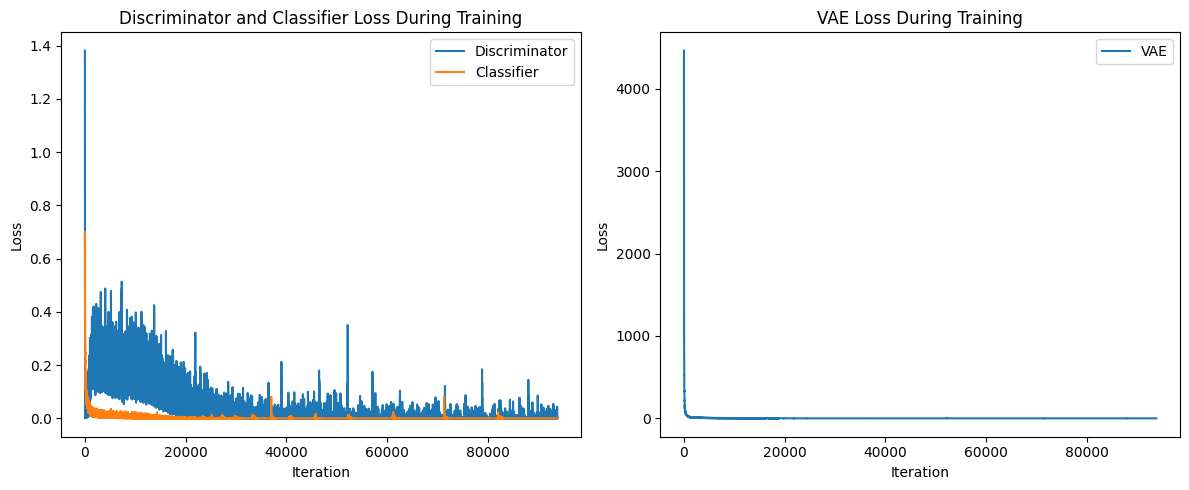

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot losses for Discriminator and Classifier
ax1.set_title("Discriminator and Classifier Loss During Training")
ax1.plot(losses_D,label="Discriminator")
ax1.plot(losses_C,label="Classifier")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot loss for VAE
ax2.set_title("VAE Loss During Training")
ax2.plot(losses_G,label="VAE")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Loss")
ax2.legend()

plt.tight_layout()
plt.show()

(362, 242, 3)


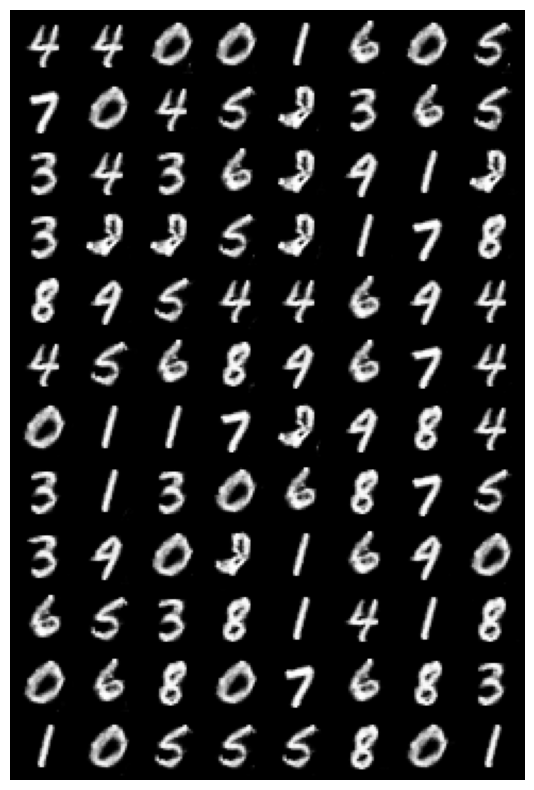

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# 加载生成的图片
fake_images = plt.imread('./img_CVAE-GAN/fake_images-{}.png'.format(nepoch+25))
print(fake_images.shape)
fake_images = np.transpose(fake_images, (2, 0, 1))

# 显示生成的图片
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(fake_images, (1, 2, 0)))
plt.axis("off")
plt.show()